In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

import wfg
import numpy as np
import n_sphere
import matplotlib.pyplot as plt
from testsuite.utilities import Pareto_split, get_target_igd_refpoints

In [2]:
def cartesian_to_spherical(x):
    """
    converts n-dimensional, cartesian coordinates x into 
    polar coordinates
    """
    assert x.ndim == 1
    r = np.linalg.norm(x)
    n = x.shape[0]-1
    
    phi_n_1 = np.arccos(x[n-1]/(np.sqrt(np.sum(x[n-1:]**2))))
    if x[-1]< 0:
        phi_n_1 = (2*np.pi)-phi_n_1
        
    phi_n_2 = np.arccos(x[n-2]/(np.sqrt(np.sum(x[n-2:]**2))))
    
    phi = [np.arccos(x[i]/np.sqrt(np.sum(x[i:]**2))) for i in range(n-2)]
    return np.array([*phi, phi_n_2, phi_n_1]), r

def spherical_to_cartesian(phis, r):
    """
    converts n-1 dimensional array of angles phis, and radius
    r into n-dimensional cartesian coordinates
    """
    phis= np.array(phis)
    n = phis.shape[0]+1
    
    x_n = r*np.product(np.sin(phis))
    x_n_1 = r*np.product(np.sin(phis[:-1]))*np.cos(phis[-1])
    
    xs = [r*np.cos(phis[i])*np.prod(np.sin(phis[:i]))for i in range(n-2)]
    
    return np.array([*xs, x_n_1, x_n])

In [3]:
def gen_points(prob_n, n_obj, kfactor, lfactor, n_points):

    M = n_obj
    k = kfactor*(M-1)   # position related params
    l = lfactor*2       # distance related params
    
    n_dim = k+l
    n_obj = M
    func = getattr(wfg, 'WFG{}'.format(int(prob_n)))

    N = n_points
    y = np.zeros((N, n_obj))
    x = np.zeros((N, n_dim))
    for n in range(N):
        z = wfg.random_soln(k, l, func.__name__)
        y[n,:] = func(z, k, M)
        x[n,:] = z
    return y

In [4]:
def find_points_from_angles(points, angles):
    # deg to rads
    angles = np.array(angles)*np.pi/180
    
    # gen ref vector against whichy to measure angles, using dot product 
    ref_point = spherical_to_cartesian(angles, 1.)
    
    # normalise length of points
    points_norm = points/np.linalg.norm(points, axis=1).reshape(-1,1)
    
    print(points_norm.shape)
    print(ref_point.shape)
    cos_point_angles = np.array([np.dot(point, ref_point) for point in points_norm])
    
    return np.argmax(cos_point_angles)
    

In [6]:
y = gen_points(prob_n=4, n_obj=2, kfactor=2, lfactor=2, n_points=100)
y = np.load('../../comp/igd_refpoints/problem_refpoints/data/wfg2_2d_refpoints')

In [7]:
t_ind_0 = find_points_from_angles(y, [33])
t_ind_1 = find_points_from_angles(y, [80])

(1301, 2)
(2,)
(1301, 2)
(2,)


(-0.09509266447065703,
 2.088851433732369,
 -0.16717383265649288,
 4.100503913992007)

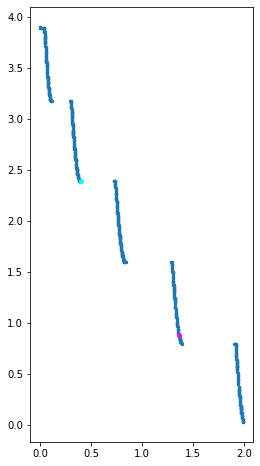

In [8]:
fig = plt.figure(figsize=[4,8])
ax = fig.gca()
ax.scatter(*y.T, s=5)
y_norm = y/np.linalg.norm(y, axis=1).reshape(-1,1)
ax.scatter(*y[t_ind_0].T, s=15, c="magenta")
ax.scatter(*y[t_ind_1].T, s=15, c="cyan")
ax.axis('equal')

## 3D

In [9]:
%matplotlib qt

In [10]:
y3 = gen_points(prob_n=6, n_obj=3, kfactor=2, lfactor=2, n_points=1000)
y3 = np.load('../../comp/igd_refpoints/problem_refpoints/data/wfg2_3d_refpoints')
y3, y3d = Pareto_split(y3)
y3.shape

(3322, 3)

In [11]:
# t3_ind = find_points_from_angles(y3, [80, 65])
# t3_ind_2 = find_points_from_angles(y3, [50, 30])
t3_ind = find_points_from_angles(y3, [80, 65])
t3_ind_2 = find_points_from_angles(y3, [33, 33])
t3_ind_2

(3322, 3)
(3,)
(3322, 3)
(3,)


2968

In [12]:
fig = plt.figure(figsize=[10, 10]) 
ax = fig.gca(projection='3d')
ax.set_box_aspect((2, 4, 6))
ax.scatter(*y3.T, s=5, alpha=0.1)
ax.set_xlim([0., 2.])
ax.set_ylim([0., 4.])
ax.set_zlim([0., 6.])
for m in [0.9, 1., 1.1]:
    ax.scatter(*y3[t3_ind]*m, s=20, c="magenta")
    ax.scatter(*y3[t3_ind_2]*m, s=20, c="cyan")

In [ ]:
fig = plt.figure(figsize=[30,10])
ax0 = fig.add_subplot(131, projection='3d')
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')

for ax, m in zip(fig.axes, [0.8, 1., 1.2]):
    t1 = y3[t3_ind]*m
    t2 = y3[t3_ind_2]*m
    igd_points1, other_points1 = get_target_igd_refpoints(t1, y3) 
    igd_points2, other_points2 = get_target_igd_refpoints(t2, y3) 
    other_points = np.array([p for p in other_points1 if p in other_points2 ])
#     ax.scatter(*other_points.T, s=5, alpha=0.1)
    ax.scatter(*t1, s=20, c="magenta", marker ='^')
    ax.scatter(*igd_points1.T, s=5, c="magenta", alpha=0.2)
    ax.scatter(*other_points.T, s=5, c="lightgrey", alpha=0.2)
    ax.scatter(*t2, s=20, c="cyan", marker ='^')
    ax.scatter(*igd_points2.T, s=5, c="cyan", alpha=0.2)


3244 79
3215 108
3322 1
3322 1
3322 1
3322 1


### 4D

In [33]:
# y4 = gen_points(prob_n=4, n_obj=4, kfactor=2, lfactor=2, n_points=100000)
y4 = np.load('../../comp/igd_refpoints/problem_refpoints/data/wfg_elipse_4d_refpoints')[::5]
y4.shape

(5787, 4)

In [34]:
ans = np.array([cartesian_to_spherical(y4i)[0] for y4i in y4])
ans.shape

(5787, 3)

In [35]:
t4_ind = find_points_from_angles(y4, [80, 30, 30])
t4_ind2 = find_points_from_angles(y4, [65, 65, 65])

(5787, 4)
(4,)
(5787, 4)
(4,)


In [36]:
fig = plt.figure(figsize=[20, 10]) 
ax0  = fig.add_subplot(241)
ax1  = fig.add_subplot(242)
ax2  = fig.add_subplot(243)
ax3  = fig.add_subplot(244)
ax4  = fig.add_subplot(245)
ax5  = fig.add_subplot(246)
ax6  = fig.add_subplot(247)

y = y4[:, :2]
t1 = y[t4_ind]
t2 = y[t4_ind2]
igd_points1, other_points1 = get_target_igd_refpoints(t1, y) 
igd_points2, other_points2 = get_target_igd_refpoints(t2, y) 
yp = np.array([p for p in other_points1 if p in other_points2])
ax0.scatter(*yp.T, s=5, c="lightgrey")
ax0.scatter(*t1, s=20, c="magenta")
ax0.scatter(*t2, s=20, c="cyan")

# ax1.scatter(*y4[:,1:3].T, s=5)
# ax1.scatter(*y4[:, 1:3][t4_ind], s=20, c="magenta")
# ax1.scatter(*y4[:, 1:3][t4_ind2], s=20, c="cyan")

# ax2.scatter(*y4[:,2:4].T, s=5)
# ax2.scatter(*y4[:, 2:4][t4_ind], s=20, c="magenta")
# ax2.scatter(*y4[:, 2:4][t4_ind2], s=20, c="cyan")

# ax3.scatter(*y4[:,[0, 2]].T, s=5)
# ax3.scatter(*y4[:, [0, 2]][t4_ind], s=20, c="magenta")
# ax3.scatter(*y4[:, [0, 2]][t4_ind2], s=20, c="cyan")

# ax4.scatter(*y4[:,[0, 3]].T, s=5)
# ax4.scatter(*y4[:, [0, 3]][t4_ind], s=20, c="magenta")
# ax4.scatter(*y4[:, [0, 3]][t4_ind2], s=20, c="cyan")

# ax5.scatter(*y4[:,[1, 3]].T, s=5)
# ax5.scatter(*y4[:, [1, 3]][t4_ind], s=20, c="magenta")
# ax5.scatter(*y4[:, [1, 3]][t4_ind2], s=20, c="cyan")

# ax6.scatter(*y4[:,[1, 2]].T, s=5)
# ax6.scatter(*y4[:, [1, 2]][t4_ind], s=20, c="magenta")
# ax6.scatter(*y4[:, [1, 2]][t4_ind2], s=20, c="cyan")

12 5776
12 5776


In [39]:
igd_points1.shape

(5776, 2)

In [40]:
other_points1.shape

(12, 2)

In [37]:
fig = plt.figure(figsize=[20, 10]) 
ax0  = fig.add_subplot(241)
ax1  = fig.add_subplot(242)
ax2  = fig.add_subplot(243)
ax3  = fig.add_subplot(244)
ax4  = fig.add_subplot(245)
ax5  = fig.add_subplot(246)
ax6  = fig.add_subplot(247)


igd_points1, other_points1 = get_target_igd_refpoints(t1, y3) 
ax0.scatter(*y4[:,:2].T, s=5)
ax0.scatter(*y4[:, :2][t4_ind], s=20, c="magenta")
ax0.scatter(*y4[:, :2][t4_ind2], s=20, c="cyan")

ax1.scatter(*y4[:,1:3].T, s=5)
ax1.scatter(*y4[:, 1:3][t4_ind], s=20, c="magenta")
ax1.scatter(*y4[:, 1:3][t4_ind2], s=20, c="cyan")

ax2.scatter(*y4[:,2:4].T, s=5)
ax2.scatter(*y4[:, 2:4][t4_ind], s=20, c="magenta")
ax2.scatter(*y4[:, 2:4][t4_ind2], s=20, c="cyan")

ax3.scatter(*y4[:,[0, 2]].T, s=5)
ax3.scatter(*y4[:, [0, 2]][t4_ind], s=20, c="magenta")
ax3.scatter(*y4[:, [0, 2]][t4_ind2], s=20, c="cyan")

ax4.scatter(*y4[:,[0, 3]].T, s=5)
ax4.scatter(*y4[:, [0, 3]][t4_ind], s=20, c="magenta")
ax4.scatter(*y4[:, [0, 3]][t4_ind2], s=20, c="cyan")

ax5.scatter(*y4[:,[1, 3]].T, s=5)
ax5.scatter(*y4[:, [1, 3]][t4_ind], s=20, c="magenta")
ax5.scatter(*y4[:, [1, 3]][t4_ind2], s=20, c="cyan")

ax6.scatter(*y4[:,[1, 2]].T, s=5)
ax6.scatter(*y4[:, [1, 2]][t4_ind], s=20, c="magenta")
ax6.scatter(*y4[:, [1, 2]][t4_ind2], s=20, c="cyan")

In [260]:
Y4[t4_ind]

array([1.47153967, 2.41276036, 1.28539633, 1.76922688])